<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_20/S20_StableDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git -C ERA_V1 pull

Cloning into 'ERA_V1'...
remote: Enumerating objects: 1761, done.
remote: Counting objects: 100% (354/354), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 1761 (delta 148), reused 287 (delta 114), pack-reused 1407
Receiving objects: 100% (1761/1761), 230.63 MiB | 15.57 MiB/s, done.
Resolving deltas: 100% (840/840), done.
Updating files: 100% (197/197), done.
Already up to date.


In [2]:
import os
import sys
sys.path.append('/content/ERA_V1/session_20')

In [3]:
%pip install -qq -U datasets transformers pyarrow==9.0.0
%pip install -qq --upgrade transformers==4.25.1 diffusers ftfy accelerate
%pip install -qq colorsys

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [79]:
from base64 import b64encode

import numpy as np
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel

from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging, CLIPVisionModel, AutoProcessor
import os
import cv2
import torchvision.transforms as T

torch.manual_seed(1)
logging.set_verbosity_error()

torch_device = "cuda" if torch.cuda.is_available() else "cpu"


In [37]:
# Load the autoencoder
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='vae')

# Load tokenizer and text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# Unet model for generating latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='unet')

# Noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# CLIP Vision Model
clip_vision_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
clip_vision_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")


# Move everything to GPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

**Generate Clip embeddings for input text embeddings**

In [8]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

**Generate with input embeddings**

**Create custom embeddings**

In [9]:
style_files = ['/content/ERA_V1/session_20/learned_embeds_style_0.bin',
               '/content/ERA_V1/session_20/learned_embeds_style_10.bin',
               '/content/ERA_V1/session_20/learned_embeds_style_2.bin',
               '/content/ERA_V1/session_20/learned_embeds_style_5.bin',
               '/content/ERA_V1/session_20/learned_embeds_style_8.bin']

def get_style_embeddings(style_file):
    style_embed = torch.load(style_file)
    style_name = list(style_embed.keys())[0]
    return style_embed[style_name]

def get_EOS_pos_in_prompt(prompt):
    return len(prompt.split())+1

**Define Custom Loss**

In [80]:
def rgb2hsv_torch(rgb: torch.Tensor) -> torch.Tensor:
    cmax, cmax_idx = torch.max(rgb, dim=1, keepdim=True)
    cmin = torch.min(rgb, dim=1, keepdim=True)[0]
    delta = cmax - cmin
    hsv_h = torch.empty_like(rgb[:, 0:1, :, :])
    cmax_idx[delta == 0] = 3
    hsv_h[cmax_idx == 0] = (((rgb[:, 1:2] - rgb[:, 2:3]) / delta) % 6)[cmax_idx == 0]
    hsv_h[cmax_idx == 1] = (((rgb[:, 2:3] - rgb[:, 0:1]) / delta) + 2)[cmax_idx == 1]
    hsv_h[cmax_idx == 2] = (((rgb[:, 0:1] - rgb[:, 1:2]) / delta) + 4)[cmax_idx == 2]
    hsv_h[cmax_idx == 3] = 0.
    hsv_h = hsv_h/6.
    hsv_s = torch.where(cmax == 0, torch.tensor(0.).type_as(rgb), delta / cmax)
    hsv_v = cmax
    output = torch.cat([hsv_h, hsv_s, hsv_v], dim=1)
    return output

def hsv_loss(gen_image):
    gen_image_hsv = rgb2hsv_torch(gen_image.clone())
    gen_image_hsv_output = gen_image_hsv.clone()
    loss = torch.abs(gen_image_hsv_output[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return loss

def invert_loss(gen_image):
    inverter = T.RandomInvert()
    inverted_img = inverter(gen_image)
    loss = torch.abs(gen_image-inverted_img).mean() # [:,2] -> all images in batch, only the blue channel
    return loss

def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return error

def clip_loss(gen_image):
    print("inside clip loss")
    # read the input RGB image as BGR format
    target_sentence = "rainbow"
    # tokenize
    text_input = tokenizer(target_sentence, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = text_input.input_ids.to(torch_device)
    # get token embeddings
    token_emb_layer = text_encoder.text_model.embeddings.token_embedding
    token_embeddings = token_emb_layer(input_ids)
    text_embeddings = token_embeddings[0,1,:].unsqueeze(0)
    text_embeddings.requires_grad_()
    # get image embeddings
    np_array = np.array(gen_image.squeeze().permute((1,2,0)).detach().cpu())
    inputs = clip_vision_processor(images=np_array, return_tensors="pt")
    outputs = clip_vision_model(**inputs)
    image_embeddings = outputs[1]
    image_embeddings.requires_grad_()

    # Convert to numpy array
    mse_loss = torch.torch.nn.functional.mse_loss(image_embeddings.cuda(), text_embeddings)
    print(mse_loss)
    return mse_loss

**Get the custom embeddings**

In [82]:
from torchvision.transforms import ToTensor
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def additional_guidance(latents, scheduler, noise_pred, t, sigma, custom_loss_fn, custom_loss_scale):
    #### ADDITIONAL GUIDANCE ###
    # Requires grad on the latents
    latents = latents.detach().requires_grad_()

    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred
    print(f"latents: {latents.shape}, noise_pred:{noise_pred.shape}")
    #latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

    # Decode to image space
    denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)
    #denoised_images = np.asarray(denoised_images.detach().cpu())

    # Calculate loss
    loss = custom_loss_fn(denoised_images) * custom_loss_scale
    #print(loss)

    #with torch.autograd.set_detect_anomaly(True):
    # Get gradient
    cond_grad = torch.autograd.grad(loss, latents, allow_unused=False)[0]
    #print(cond_grad)

    # Modify the latents based on this gradient
    latents = latents.detach() - cond_grad * sigma**2
    return latents, loss


def generate_with_embs(text_embeddings, max_length, random_seed, custom_loss_fn = None, custom_loss_scale=1.0):
    height = 64                        # default height of Stable Diffusion
    width = 64                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(random_seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        if custom_loss_fn is not None:
            if i%5 == 0:
                latents, custom_loss = additional_guidance(latents, scheduler, noise_pred, t, sigma, custom_loss_fn, custom_loss_scale)
                print(i, 'loss:', custom_loss.item())

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [12]:
def generate_image_with_custom_style(prompt, style_num=None, random_seed=41, custom_loss_fn = None, custom_loss_scale=1.0):
    eos_pos = get_EOS_pos_in_prompt(prompt)

    style_token_embedding = None
    if style_num:
        style_token_embedding = get_style_embeddings(style_files[style_num])

    # tokenize
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    max_length = text_input.input_ids.shape[-1]
    input_ids = text_input.input_ids.to(torch_device)

    # get token embeddings
    token_emb_layer = text_encoder.text_model.embeddings.token_embedding
    token_embeddings = token_emb_layer(input_ids)

    # Append style token towards the end of the sentence embeddings
    if style_token_embedding is not None:
        token_embeddings[-1, eos_pos, :] = style_token_embedding

    # combine with pos embs
    pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
    position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
    position_embeddings = pos_emb_layer(position_ids)
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And generate an image with this:
    generated_image = generate_with_embs(modified_output_embeddings, max_length, random_seed, custom_loss_fn, custom_loss_scale)
    return generated_image

In [13]:
def show_images(images_list):
    # Let's visualize the four channels of this latent representation:
    fig, axs = plt.subplots(1, len(images_list), figsize=(16, 4))
    for c in range(len(images_list)):
        axs[c].imshow(images_list[c])
    plt.show()

<ipython-input-82-511ac58c066d>:67: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
0 loss: 0.0
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
5 loss: 0.0
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
10 loss: 102.54340362548828
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
15 loss: 87.3738021850586
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
20 loss: 0.0
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
25 loss: 0.0


  0%|          | 0/30 [00:00<?, ?it/s]

latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
0 loss: 0.0
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
5 loss: 0.0
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
10 loss: 0.0
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
15 loss: 0.0
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
20 loss: 81.23284912109375
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
25 loss: 69.67808532714844


  0%|          | 0/30 [00:00<?, ?it/s]

latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
0 loss: 0.0
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
5 loss: 0.0
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
10 loss: 0.0
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
15 loss: 80.71102905273438
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
20 loss: 50.82316970825195
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
25 loss: 42.15530014038086


  0%|          | 0/30 [00:00<?, ?it/s]

latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
0 loss: 0.0
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
5 loss: 0.0
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
10 loss: 81.7270278930664
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
15 loss: 59.36384963989258
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
20 loss: 0.0
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
25 loss: 0.0


  0%|          | 0/30 [00:00<?, ?it/s]

latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
0 loss: 88.07365417480469
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
5 loss: 0.0
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
10 loss: 108.5062484741211
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
15 loss: 107.3567886352539
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
20 loss: 106.92115783691406
latents: torch.Size([1, 4, 8, 8]), noise_pred:torch.Size([1, 4, 8, 8])
25 loss: 0.0


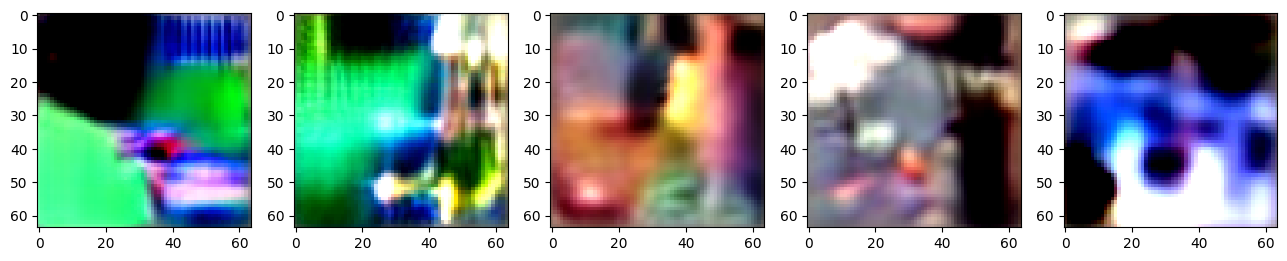

In [83]:
outputs = []
seed_values = [1,2,3,4,5]
prompt = "A dog riding a skateboard"
custom_loss_fn = invert_loss
#custom_loss_fn = blue_loss
custom_loss_scale = 100.0
num_styles = len(style_files)
for cnt in range(num_styles):
    this_generated_img = generate_image_with_custom_style(prompt,
                                                          style_num = cnt,
                                                          random_seed = seed_values[cnt],
                                                          custom_loss_fn = custom_loss_fn,
                                                          custom_loss_scale = custom_loss_scale)
    outputs.append(this_generated_img)
show_images(outputs)



In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [49]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPVisionModel

model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
print(image)

inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output  # pooled CLS states

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7FCEC77B04C0>


In [38]:
outputs[1].shape

torch.Size([1, 768])